In [31]:
# read data, the auto-mpg dataset
# goal - to predict the MPG

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fpath = 'auto-mpg.data'

df = pd.read_csv(
    fpath, 
    header=None,
    delim_whitespace=True
)

df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'car']

df = df.loc[df.loc[:, 'horsepower'] != '?', :]
df.loc[:, 'horsepower'] = df.loc[:, 'horsepower'].astype('float64')

for c in ['mpg', 'weight', 'horsepower', 'displacement']:
    df.loc[:, c] = np.log1p(df.loc[:, c])

df = df.loc[:, df.columns != 'car']
    
def split(df, target, thr=0.75):
    df = df.sample(frac=1)
    
    thr = int(len(df)*thr)
        
    train, test = df.iloc[:thr, :], df.iloc[thr:, :]
    
    X_train, X_test = train.loc[:, train.columns != target], test.loc[:, test.columns != target]
    y_train, y_test = train.loc[:, target], test.loc[:, target]

    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = split(df, 'mpg')

X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,year,origin
396,4,4.795791,4.382027,7.873217,18.6,82,1
234,4,5.023881,4.488636,7.916078,16.0,77,1
251,8,5.713733,4.941642,8.180601,12.8,78,1
226,6,5.446737,4.663439,8.139149,16.9,77,1
10,8,5.950643,5.141664,8.178639,10.0,70,1


1.0.0


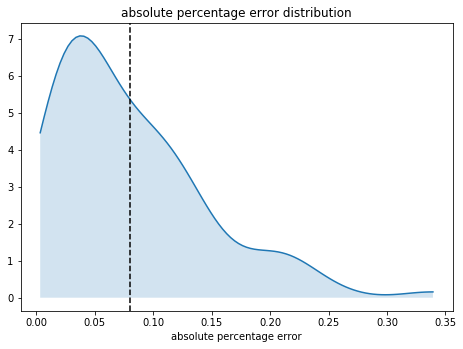

mape: 0.08013711438884395


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


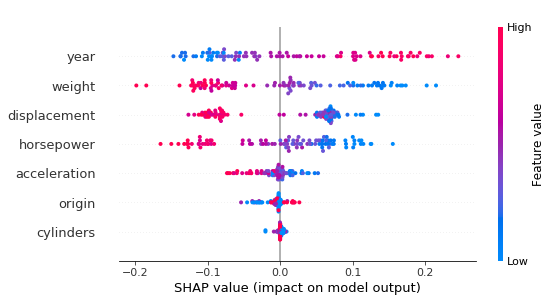

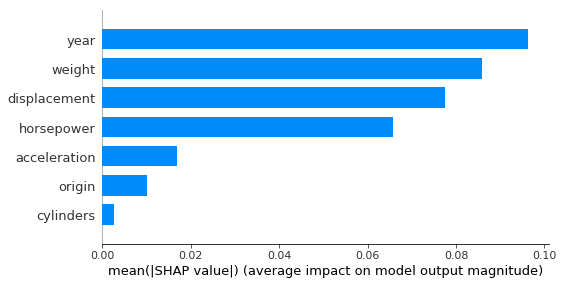

In [32]:
# train simple xgb model

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
import shap
import scipy.stats as st

print(xgb.__version__)

param = {
    'objective': 'reg:squarederror',
    'eta': 0.2
}

num_round = 200

features = X_train.columns.values

xg_train = xgb.DMatrix(
    X_train.values, feature_names = features, label = y_train.values
)
xg_test = xgb.DMatrix(
    X_test.values, feature_names = features, label = y_test.values
)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
reg = xgb.train(
    param, xg_train, num_round, watchlist, verbose_eval=False, early_stopping_rounds=10
)

preds = reg.predict(xg_test)

preds_convert = np.e**preds + 1
y_test_convert = np.e**y_test + 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

data = abs(preds_convert - y_test_convert) / y_test_convert

kde_xs = np.linspace(min(data), max(data), 100)
kde = st.gaussian_kde(data)

ax.plot(
    kde_xs, 
    kde.pdf(kde_xs)
)

ax.fill_between(
    kde_xs, 
    kde.pdf(kde_xs),
    alpha=0.2
)

ax.axvline(x=np.mean(abs(y_test_convert - preds_convert) / y_test_convert), color='black', linestyle='--')

plt.title('absolute percentage error distribution')
plt.xlabel('absolute percentage error')
plt.show()

mape = np.mean(abs(y_test_convert - preds_convert) / y_test_convert)
print(f'mape: {mape}')

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='dot')
shap.summary_plot(shap_values, X_test, plot_type='bar')

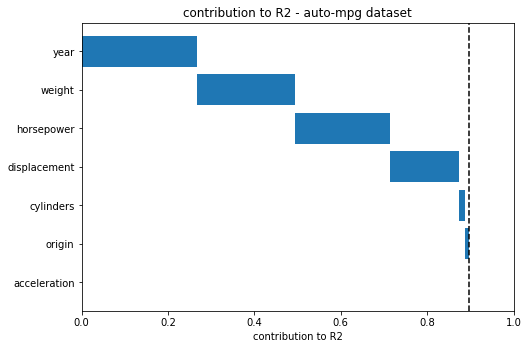

,r2,error_var,error_var_shap,error_ratio,r2_shap
variable,,,,,
acceleration,0.897379,0.009944,0.009210,1.000000,0.000000
origin,0.897379,0.009944,0.010161,0.978669,0.010477
cylinders,0.897379,0.009944,0.010229,0.972188,0.013660
displacement,0.897379,0.009944,0.014709,0.676080,0.159099
horsepower,0.897379,0.009944,0.017970,0.553387,0.219362
weight,0.897379,0.009944,0.018604,0.534523,0.228627
year,0.897379,0.009944,0.021707,0.458123,0.266153


In [33]:
# decomposing R2 of a regression model, credit here: https://github.com/nredell/shapFlex#asymmetric-causal-shapley-values
# original paper: https://arxiv.org/pdf/1908.09718.pdf

import shap

shap_df = pd.DataFrame(shap_values)
shap_df.columns = X_test.columns
intercept = explainer.expected_value

# decompose the R2 of a regressor into each feature
def shap_decompose_r2(shap, y, intercept, scale):

    # get preds
    y_pred = shap.sum(axis=1) + intercept
    
    # fix index for joining
    shap.index = list(range(len(shap)))
    y.index = list(range(len(y)))
    y_pred.index = list(range(len(y_pred)))

    # baseline R2
    y_pred_var = np.var(y_pred)
    error_var = np.var(y - y_pred)
    r2 = y_pred_var / (y_pred_var + error_var)
    
    # melt dataframe into long format
    data = pd.melt(shap.reset_index(), id_vars='index',value_vars=shap.columns)
    data.index = data.loc[:, 'index']
    data = data.loc[:, data.columns != 'index']
    
    # add stuff to the dataframe
    data.loc[:, 'y'] = y
    data.loc[:, 'y_pred'] = y_pred
    data.loc[:, 'error'] = data.loc[:, 'y'] - data.loc[:, 'y_pred']    
    data.loc[:, 'y_pred_shap'] = data.loc[:, 'y_pred'] - data.loc[:, 'value']
    data.loc[:, 'r2'] = r2
    data.loc[:, 'error_var'] = error_var 
    data.loc[:, 'error_var_shap'] = data.loc[:, 'y'] - data.loc[:, 'y_pred_shap']
    
    # error variance per variable
    error_var_shap = data.groupby(['variable']).var().loc[:, 'error_var_shap']
    
    # merge
    data = data.loc[:, data.columns != 'error_var_shap'].merge(error_var_shap, left_on='variable', right_index=True)
    
    # error ratio
    data.loc[:, 'error_ratio'] = data.loc[:, 'error_var'] / data.loc[:, 'error_var_shap']    
    data.loc[:, 'error_ratio'] = np.clip(data.loc[:, 'error_ratio'], 0, 1)
    
    # distinct error ratio per variable
    data = data.groupby(['variable']).min()
    data = data.loc[:,data.columns.isin(['error_var','r2','error_var_shap','error_ratio','r2_shap'])]
    
    # calculate r2_shap
    data.loc[:, 'r2_shap'] = data.loc[:, 'r2'] - data.loc[:, 'error_ratio'] * data.loc[:, 'r2']
    data.loc[:, 'r2_shap'] /= data.loc[:, 'r2_shap'].sum()
    
    if scale:
        data.loc[:, 'r2_shap'] *= data.loc[:, 'r2']

    return data

r2_decomp = shap_decompose_r2(shap_df, y_test, intercept, scale=True)

r2_decomp = r2_decomp.sort_values(['r2_shap'])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.barh(
    r2_decomp.index,
    r2_decomp.loc[:, 'r2_shap'],
    left=r2_decomp.loc[:, 'r2_shap'].sum() - r2_decomp.loc[:, 'r2_shap'].cumsum()
)

ax.axvline(r2_decomp.loc[:, 'r2_shap'].sum(), color='black', linestyle='--')

plt.xlim(0,1)
plt.title('contribution to R2 - auto-mpg dataset')
plt.xlabel('contribution to R2')
plt.show()

r2_decomp

In [34]:
# read data, the wine quality dataset
# goal - to predict the quality, as a classification task

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fpath = 'winequality-red.csv'

df = pd.read_csv(
    fpath,
    delimiter=';'
)

mdn = df.loc[:, 'quality'].median()
df.loc[:, 'quality'] = df.loc[:, 'quality'].apply(lambda x: 1 if x >= mdn else 0)

for c in ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','sulphates','alcohol']:
    df.loc[:, c] = np.log1p(df.loc[:, c])

def split(df, target, thr=0.75):
    df = df.sample(frac=1)
    
    thr = int(len(df)*thr)
        
    train, test = df.iloc[:thr, :], df.iloc[thr:, :]
    
    X_train, X_test = train.loc[:, train.columns != target], test.loc[:, test.columns != target]
    y_train, y_test = train.loc[:, target], test.loc[:, target]

    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = split(df, 'quality')

X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
754,2.174752,0.392042,0.518794,0.993252,0.347130,2.708050,3.496508,0.99656,3.09,0.722706,2.312535
137,2.104134,0.347130,0.307485,1.098612,0.077887,2.639057,3.828641,0.99720,3.48,0.494696,2.322388
501,2.433613,0.364643,0.548121,2.021548,0.071390,3.663562,4.343805,0.99900,3.17,0.615186,2.564949
1388,2.028148,0.494696,0.270027,1.960095,0.079735,2.079442,3.912023,0.99718,3.35,0.518794,2.424803
326,2.533697,0.425268,0.506818,1.536867,0.114221,1.945910,2.708050,0.99780,3.05,0.553885,2.525729


1.0.0
auc: 0.881144496529112


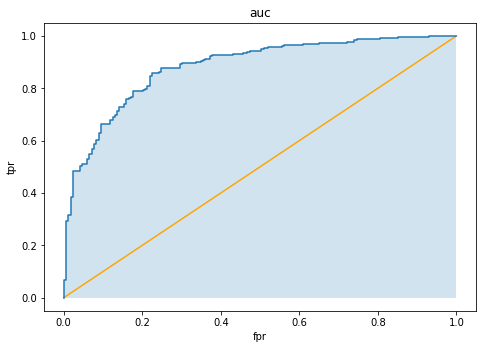

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


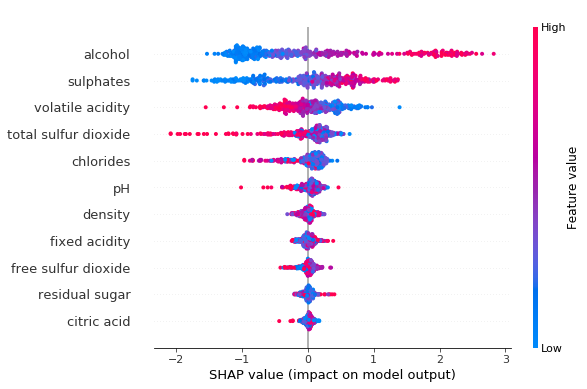

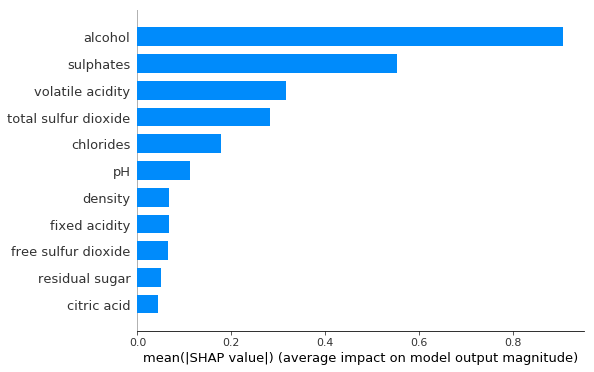

In [35]:
# train simple xgb model

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
import shap
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

print(xgb.__version__)

param = {
    'objective': 'binary:logistic',
    'eta': 0.2
}

num_round = 200

features = X_train.columns.values

xg_train = xgb.DMatrix(
    X_train.values, feature_names = features, label = y_train.values
)
xg_test = xgb.DMatrix(
    X_test.values, feature_names = features, label = y_test.values
)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
reg = xgb.train(
    param, xg_train, num_round, watchlist, verbose_eval=False, early_stopping_rounds=10
)

preds = reg.predict(xg_test)

probs = reg.predict(xg_test)
auc = roc_auc_score(y_test, probs)

print(f'auc: {auc}')

fpr, tpr, _ = roc_curve(y_test, probs)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(
    np.linspace(0,1,100),
    np.linspace(0,1,100),
    color='orange'
)
ax.plot(
    fpr,
    tpr
)

ax.fill_between(
    fpr,
    tpr,
    alpha=0.2
)

plt.title('auc')
plt.xlabel('fpr')
plt.ylabel('tpr')

plt.show()

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='dot')
shap.summary_plot(shap_values, X_test, plot_type='bar')

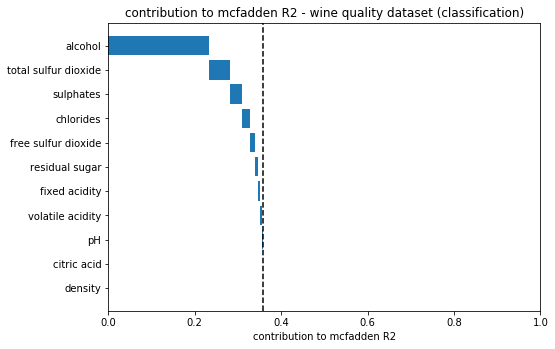

,null_log_likelihood,shap_log_likelihood,shap_log_likelihood_adjust,mcfadden_r2_orig,mcfadden_r2_adjust,r2_increase
variable,,,,,,
density,-274.648934,-176.014923,-175.895172,0.359128,0.359564,0.000000
citric acid,-274.648934,-176.014923,-176.207030,0.359128,0.358428,0.000979
pH,-274.648934,-176.014923,-176.543748,0.359128,0.357202,0.002695
volatile acidity,-274.648934,-176.014923,-176.756863,0.359128,0.356426,0.003782
fixed acidity,-274.648934,-176.014923,-177.156373,0.359128,0.354972,0.005818
residual sugar,-274.648934,-176.014923,-177.461590,0.359128,0.353860,0.007373
free sulfur dioxide,-274.648934,-176.014923,-177.869918,0.359128,0.352374,0.009455
chlorides,-274.648934,-176.014923,-179.825055,0.359128,0.345255,0.019420
sulphates,-274.648934,-176.014923,-181.289067,0.359128,0.339924,0.026881


In [36]:
# decomposing the mcfadden R2 of a binary classifier model, inspired by: https://github.com/nredell/shapFlex#asymmetric-causal-shapley-values

shap_df = pd.DataFrame(shap_values)
shap_df.columns = X_test.columns
intercept = explainer.expected_value

def logit2prob(logit):
    odds = np.exp(logit)
    return odds / ( 1 + odds )

def log_likelihood(logit):
    return -np.log(1 + np.exp(logit))

# decompose the pesudo-R2 of a classifier into each feature
def shap_decompose_logistic(shap, y, intercept, scale):

    # get preds
    shap_logits = shap.sum(axis=1) + intercept
    y_pred = logit2prob(shap_logits)

    # fix index for joining
    shap.index = list(range(len(shap)))
    y.index = list(range(len(y)))

    # melt dataframe into long format
    data = pd.melt(shap.reset_index(), id_vars='index',value_vars=shap.columns)
    data.index = data.loc[:, 'index']
    data = data.loc[:, data.columns != 'index']
    data.loc[:, 'shap_logit'] = shap_logits
    data.loc[:, 'y'] = y

    # get null, full and adjusted log_likelihoods
    data.loc[:, 'null_log_likelihood'] = log_likelihood(intercept) + y * intercept
    data.loc[:, 'shap_log_likelihood'] = log_likelihood(shap_logits) + y * shap_logits

    shap_logits_adjust = data.loc[:, 'shap_logit'] - data.loc[:, 'value']
    data.loc[:, 'shap_log_likelihood_adjust'] = log_likelihood(shap_logits_adjust) + data.loc[:, 'y'] * shap_logits_adjust

    # sum per variable
    data = data.groupby(['variable']).sum()
    data = data.loc[:,data.columns.isin(['null_log_likelihood','shap_log_likelihood','shap_log_likelihood_adjust','error_ratio','r2_shap'])]

    # calculate mcfadden
    data.loc[:, 'mcfadden_r2_orig'] = 1 - (data.loc[:, 'shap_log_likelihood'] / data.loc[:, 'null_log_likelihood'])
    data.loc[:, 'mcfadden_r2_adjust'] = 1 - (data.loc[:, 'shap_log_likelihood_adjust'] / data.loc[:, 'null_log_likelihood'])
    data.loc[:, 'r2_increase'] = np.clip(data.loc[:, 'mcfadden_r2_orig'] - data.loc[:, 'mcfadden_r2_adjust'],0,1)

    # optionally scale
    if scale:
        data.loc[:, 'r2_increase'] /= data.loc[:, 'r2_increase'].sum()
        data.loc[:, 'r2_increase'] *= data.loc[:, 'mcfadden_r2_orig']

    return data

log_decomp = shap_decompose_logistic(shap_df, y_test, intercept, scale=True)

log_decomp = log_decomp.sort_values(['r2_increase'])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.barh(
    log_decomp.index,
    log_decomp.loc[:, 'r2_increase'],
    left=log_decomp.loc[:, 'r2_increase'].sum() - log_decomp.loc[:, 'r2_increase'].cumsum()
)

ax.axvline(log_decomp.loc[:, 'r2_increase'].sum(), color='black', linestyle='--')

plt.xlim(0,1)
plt.title('contribution to mcfadden R2 - wine quality dataset (classification)')
plt.xlabel('contribution to mcfadden R2')
plt.show()

log_decomp
